### Using Google Colab

This notebook has the pip command for installing MONAI and will be added to any subsequent notebook.

**Required Packages for Colab Execution**

Execute the following cell to install MONAI the first time a colab notebook is run:


In [1]:
!pip install -qU "monai[ignite, nibabel, torchvision, tqdm]==0.5.0"

**Enabling GPU Support**

To use GPU resources through Colab, change the runtime to GPU:

1. From the **"Runtime"** menu select **"Change Runtime Type"**
2. Choose **"GPU"** from the drop-down menu
3. Click **"SAVE"**

This will reset the notebook and probably ask you if you are a robot (these instructions assume you are not). Running

**!nvidia-smi**

in a cell will verify this has worked and show you what kind of hardware you have access to.    

In [2]:
!nvidia-smi

Mon Apr 19 20:58:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-PCIE-40GB      On   | 00000000:0A:00.0 Off |                    0 |
| N/A   38C    P0    33W / 250W |   7446MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# MONAI Sliding Inference and Post-processing
---

To run model inferences and evaluate the model quality, MONAI provides reference implementations for the relevant widely-used approaches. Currently, several popular evaluation metrics and inference patterns are included.

MONAI also includes post-processing tranform functions to help handle the model outputs like removing segmentation noise or extracting contour of segmentation results.

## MONAI Sliding Inference and Post-processing

To help you understand more about MONAI Datasets and Caching options, this guide will help you answer five key questions:

1. **What is sliding inference?**
2. **What are post-processing transforms?**
3. **How do I use sliding inference on real data?**
4. **How do I use post-processing on my sliding inference results?**
5. **How can I use tensorboard to visualize the results?**


Let's get started by importing our dependencies.  We'll also use the Jupyter load extension command to load tensorboard so we can vizualize our results later.

In [3]:
%load_ext tensorboard

import monai
monai.config.print_config()

MONAI version: 0.5.0
Numpy version: 1.19.2
Pytorch version: 1.7.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 2707407fed8c78ccb1c18d1e994a68580457219e

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.1
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 8.1.0
Tensorboard version: 2.4.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.59.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## **1. What is sliding inference?**

#### A toy model for inference
For model inferences on large volumes, the sliding window approach is a popular choice to achieve high performance while having flexible memory requirements. It also supports overlap and blending_mode configurations to handle the overlapped windows for better performances.

A typical process is:

- Select continuous windows on the original image.
- Iteratively run batched window inferences until all windows are analyzed.
- Aggregate the inference outputs to a single segmentation map.
- Save the results to file or compute some evaluation metrics.

<img src="sliding_window.png" style="width: 700px;"/>

The [sliding_window_inference](https://docs.monai.io/en/latest/inferers.html?highlight=sliding#sliding-window-inference) requires a callable function which takes a batch of image windows as the input.

Here we construct a toy model. It has a single model parameter, `self.pred`. The inference outcome is just `input + self.pred`.

Every time the model is called, it also increases `self.pred` by one. This is to demonstrate that the model can be "stateful", and also so that we can conveniently visualize the inference outputs.

In [4]:
class ToyModel:
    # A simple model generates the output by adding an integer `pred` to input.
    # each call of this instance increases the integer by 1.
    pred = 0
    def __call__(self, input):
        self.pred = self.pred + 1
        return input + self.pred

#### Run the inference using sliding window

We're going to create a 200x200-pixel image and pass it to `sliding_window_inference` with a 40x40 window size then display the image.

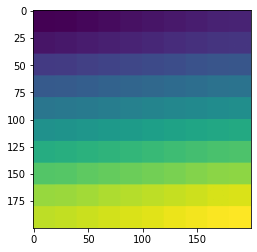

In [5]:
import torch
import matplotlib.pyplot as plt
from monai.inferers import sliding_window_inference

input_tensor = torch.zeros(1, 1, 200, 200)
output_tensor = sliding_window_inference(
    inputs=input_tensor, 
    predictor=ToyModel(), 
    roi_size=(40, 40), 
    sw_batch_size=1, 
    overlap=0.5, 
    mode="constant")
plt.imshow(output_tensor[0, 0])

#### Gaussian weighted windows
For a given input image window, the convolutional neural networks often predict the central regions more accurately than the border regions, usually due to the stacked convolutions' receptive field.

Therefore, it is worth considering a "Gaussian weighted" prediction to emphasize the central region predictions when we stitch the windows into a complete inference output.

By simply changing the inference mode to "gaussian", the sliding window module will use this "weighted stitching".

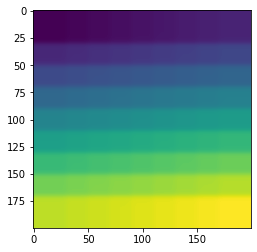

In [6]:
input_tensor = torch.zeros(1, 1, 200, 200)
output_tensor_1 = sliding_window_inference(
    inputs=input_tensor, 
    predictor=ToyModel(), 
    roi_size=(40, 40), 
    sw_batch_size=1, 
    overlap=0.5, 
    mode="gaussian")
plt.imshow(output_tensor_1[0, 0])

Compared with the previous inferences, the overlapping windows are stitched together with fewer border artifacts.

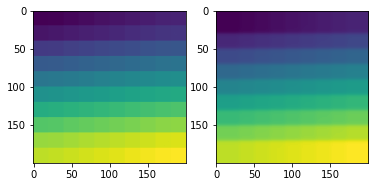

In [7]:
plt.subplots(1, 2)
plt.subplot(1, 2, 1); plt.imshow(output_tensor[0, 0])
plt.subplot(1, 2, 2); plt.imshow(output_tensor_1[0, 0])

## **2. What are post-processing transforms?**

MONAI also provides post-processing transforms for handling the model outputs. Currently, the transforms include:

- Adding activation layer (Sigmoid, Softmax, etc.).
- Converting to discrete values (Argmax, One-Hot, Threshold value, etc), as below figure (b).
- Splitting multi-channel data into multiple single channels.
- Removing segmentation noise based on Connected Component Analysis, as below figure (c).
- Extracting contour of segmentation result, which can be used to map to original image and evaluate the model, as below figure (d) and (e).

After applying the post-processing transforms, it’s easier to compute metrics, save model output into files or visualize data in the TensorBoard.

<img src="post_transforms.png" style="width: 700px;"/>

## **3. How do I use sliding inference on real data?**


This section will set up and load a [SegResNet](https://docs.monai.io/en/latest/networks.html?highlight=segresnet#segresnet) model, run sliding window inference, and post-process the model output volumes:
- Argmax to get a discrete prediction map
- Remove small isolated predicted regions
- Convert the segmentation regions into contours

We'll start by importing all of our dependencies.

In [8]:
import os
import glob

from monai.apps import download_and_extract
from monai.utils import set_determinism
from monai.data import CacheDataset, DataLoader
from monai.networks.nets import SegResNet
from monai.transforms import (
    AddChanneld,
    AsDiscrete,
    Compose,
    CropForegroundd,
    KeepLargestConnectedComponent,
    LabelToContour,
    LoadImaged,
    Orientationd,
    ScaleIntensityRanged,
    Spacingd,
    ToTensord,
)

#### Download image, set up the validation data, preprocessing transforms, and data loader

We'll create a sequence of transforms with `Compose` and use the `DecathlonDataset` method to pull and create our dataset.

In [12]:
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)
root_dir="./"
val_ds = monai.apps.DecathlonDataset(root_dir=root_dir, task="Task09_Spleen", section="validation", download=True, transform=val_transforms, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset:   0%|          | 0/8 [00:00<?, ?it/s]

Verified 'Task09_Spleen.tar', md5: 410d4a301da4e5b2f6f86ec3ddba524e.
file ./Task09_Spleen.tar exists, skip downloading.
extracted file ./Task09_Spleen exists, skip extracting.


Loading dataset: 100%|██████████| 8/8 [00:30<00:00,  3.79s/it]


#### Set up the model

We want to utilize the GPU, so we'll check to see if it's available and set it as the primary device; otherwise we'll use the CPU.

We'll then instantiate the model with the selected device.

In [13]:
import torch 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu:0")
model = SegResNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
).to(device)

In [14]:
model_path = os.path.join(root_dir, "segresnet_model_epoch30.pth")
model.load_state_dict(torch.load(model_path))
model.eval()
print(f"model from {model_path}.")

model from ./segresnet_model_epoch30.pth.


#### Run the sliding window inference

In [15]:
val_data = next(iter(val_loader))
val_data = val_data["image"].to(device)

roi_size = (88, 88, 88)
sw_batch_size = 1
with torch.no_grad():
  val_output = sliding_window_inference(
      val_data, roi_size, sw_batch_size=sw_batch_size, predictor=model, mode="gaussian", overlap=0.2)
print(val_output.shape, val_output.device)

slice_idx = 80
plt.title(f"image -- slice {slice_idx}")
plt.imshow(val_output.detach().cpu()[0, 1, :, :, 80], cmap="gray")

RuntimeError: CUDA error: no kernel image is available for execution on the device

## **4. How do I use post-processing on my sliding inference results?**

#### Post-processing: argmax over the output probabilities into a discrete map

In [ ]:
argmax = AsDiscrete(argmax=True)(val_output)
print(argmax.shape)

slice_idx = 80
plt.subplots(1, 2)
plt.subplot(1, 2, 1)
plt.title(f"image -- slice {slice_idx}")
plt.imshow(val_data.detach().cpu()[0, 0, :, :, 80], cmap="gray")

plt.subplot(1, 2, 2)
plt.title(f"argmax -- slice {slice_idx}")
plt.imshow(argmax.detach().cpu()[0, 0, :, :, 80])

#### Post-processing: connected component analysis to select the largest segmentation region

In [ ]:
largest = KeepLargestConnectedComponent(applied_labels=[1])(argmax)
print(largest.shape)

slice_idx = 80
plt.subplots(1, 2)
plt.subplot(1, 2, 1)
plt.title(f"image -- slice {slice_idx}")
plt.imshow(val_data.detach().cpu()[0, 0, :, :, 80], cmap="gray")

plt.subplot(1, 2, 2)
plt.title(f"largest component -- slice {slice_idx}")
plt.imshow(largest.detach().cpu()[0, 0, :, :, 80])

#### Post-processing: convert the region into a contour map

In [ ]:
contour = LabelToContour()(largest)
print(contour.shape)

slice_idx = 80
plt.subplots(1, 2)
plt.subplot(1, 2, 1)
plt.title(f"image -- slice {slice_idx}")
plt.imshow(val_data.detach().cpu()[0, 0, :, :, 80], cmap="gray")

plt.subplot(1, 2, 2)
plt.title(f"contour -- slice {slice_idx}")
plt.imshow(contour.detach().cpu()[0, 0, :, :, 80], cmap="Greens")

#### Visualise the contour over the original input

In [ ]:
map_image = contour + val_data

slice_idx = 80
plt.subplots(1, 2)
plt.subplot(1, 2, 1)
plt.title(f"image -- slice {slice_idx}")
plt.imshow(val_data.detach().cpu()[0, 0, :, :, 80], cmap="gray")

plt.subplot(1, 2, 2)
plt.title(f"contour -- slice {slice_idx}")
plt.imshow(map_image.detach().cpu()[0, 0, :, :, 80], cmap="gray")

For more details about the post-postprocessing transformations, please visit:
https://docs.monai.io/en/latest/transforms.html#post-processing-dict

## 5. **How can I use tensorboard to visualize the results?**

Visualising the results in animation with tensorboard (please start tensorboard manually in a separate terminal):

In [ ]:
from monai.visualize import plot_2d_or_3d_image
from torch.utils.tensorboard import SummaryWriter

with SummaryWriter(log_dir=root_dir) as writer:
    plot_2d_or_3d_image(map_image, step=0, writer=writer, tag="segmentation")
    plot_2d_or_3d_image(val_output, step=0, max_channels=2, writer=writer, tag="Probability")

In [ ]:
%tensorboard --logdir=runs

## **Summary**

We've covered MONAI Sliding Inference and Post-Processing. Here are some key highlights:

- Sliding inference runs inference on a moving window of images.  It can be helpful with large volume images and can help improve performance.
- Post Processing transforms can help make handling the model output easier

## **Next Steps**

Start exploring MONAI on your own!  There are lots of great tutorials that can help guide you along the way. You can find it on our [GitHub Organization Page](https://github.com/Project-MONAI/tutorials).  We also have all of our videos from our first ever MONAI Bootcamp available on our [Youtube Channel](https://www.youtube.com/c/ProjectMONAI)